## Investigate Naive Baseline(s) vs. BC Model

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from blue_conduit_spatial.evaluation import *
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import xgboost

In [2]:
col_name_dictionary = {'pid': 'pid', 'Property Z': 'Property Zip Code', 'Owner Type': 'Owner Type',
                       'Owner Stat': 'Owner State', 'Homestead': 'Homestead', 'Homestea_1': 'Homestead Percent',
                       'HomeSEV': 'HomeSEV', 'Land Value': 'Land Value', 'Land Impro': 'Land Improvements Value',
                       'Residentia': 'Residential Building Value', 'Resident_1': 'Residential Building Style',
                       'Commercial': 'Commercial Building Value', 'Building S': 'Building Storeys',
                       'Parcel Acr': 'Parcel Acres', 'Rental': 'Rental', 'Use Type': 'Use Type',
                       'Prop Class': 'Prop Class', 'Old Prop c': 'Old Prop class', 'Year Built': 'Year Built',
                       'USPS Vacan': 'USPS Vacancy', 'Zoning': 'Zoning', 'Future Lan': 'Future Landuse',
                       'DRAFT Zone': 'DRAFT Zone', 'Housing Co': 'Housing Condition 2012',
                       'Housing _1': 'Housing Condition 2014', 'Commerci_1': 'Commercial Condition 2013',
                       'Latitude': 'Latitude', 'Longitude': 'Longitude', 'Hydrant Ty': 'Hydrant Type',
                       'Ward': 'Ward', 'PRECINCT': 'PRECINCT', 'CENTRACT': 'CENTRACT', 'CENBLOCK': 'CENBLOCK',
                       'SL_Type': 'SL_Type', 'SL_Type2': 'SL_Type2', 'SL_Lead': 'SL_Lead', 'Ed_July': 'Ed_July',
                       'Ed_March': 'Ed_March', 'Last_Test': 'Last_Test', 'Max_Lead': 'Max_Lead',
                       'Med_Lead': 'Med_Lead', 'Num_Tests': 'Num_Tests', 'Res_Test': 'Res_Test',
                       'Sen_Test': 'Sen_Test', 'SL_private': 'SL_private_inspection',
                       'B_median_a': 'B_median_age_all_women', 'B_median_1': 'B_median_age_all_men', 
                       'B_median_2': 'B_median_age_all', 'B_median_3': 'B_median_age_all_women_white',
                       'B_median_4': 'B_median_age_all_men_white', 'B_median_5': 'B_median_age_all_white',
                       'B_median_6': 'B_median_age_all_women_black', 'B_median_7': 'B_median_age_all_men_black',
                       'B_median_8': 'B_median_age_all_black', 'B_total_bl': 'B_total_black_pop',
                       'B_total_wh': 'B_total_white_pop', 'B_married_': 'B_married_couples',
                       'B_single_w': 'B_single_women', 'B_marrie_1': 'B_married_couples_white',
                       'B_single_1': 'B_single_women_white', 'B_marrie_2': 'B_married_couples_black',
                       'B_single_2': 'B_single_women_black', 'B_marrie_3': 'B_married_couples_w_children',
                       'B_single_m': 'B_single_mothers_w_children', 'B_househol': 'B_households_w_elderly',
                       'B_househod': 'B_househod_no_elderly', 'B_aggregat': 'B_aggregate_income',
                       'B_speak_sp': 'B_speak_spanish', 'B_speak_on': 'B_speak_only_english',
                       'B_no_engli': 'B_no_english', 'B_hispanic': 'B_hispanic_household',
                       'B_imputed_': 'B_imputed_rent', 'B_impute_1': 'B_imputed_value',
                       'known_priv': 'known_private_sl', 'known_publ': 'known_public_sl', 'hydrovac': 'hydrovac',
                       'sl_priva_1': 'sl_private_type', 'sl_public_': 'sl_public_type', 'created_at': 'created_at',
                       'source': 'source', 'hv_visit': 'hv_visit', 'sl_visit': 'sl_visit', 'replaced': 'replaced',
                       'dangerous': 'dangerous', 'geometry': 'geometry'}

In [6]:
sl_df = gpd.read_file('../data/raw/flint_sl_materials/')
sl_df = sl_df.rename(col_name_dictionary, axis=1)

In [7]:
def jared_preprocessing(sl_df):
    drop_cols = ['known_private_sl', 'known_public_sl', 'hydrovac', 'created_at', 'source',
             'hv_visit', 'sl_visit', 'replaced', 'geometry', 
            'Latitude', 'Longitude']

    data = sl_df.drop(drop_cols, axis = 1)

    # Only keep labelled data
    data = data[~pd.isnull(data.dangerous)].reset_index()

    # Drop everything except target from training data
    Xdata = data.drop(['pid', 'sl_private_type', 'sl_public_type', 'dangerous'], axis = 1)

    # Build target.  Each 'dangerous' is True when sl_private_type OR sl_public_type contain lead.
    Ydata = data[['sl_private_type', 'sl_public_type', 'dangerous']]


    dummy_cols = ['Property Zip Code', 'Owner Type', 'Residential Building Style', 'Homestead', 'Building Storeys',
                  'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'USPS Vacancy', 'Housing Condition 2012',
                  'Housing Condition 2014', 'Owner State', 'Zoning', 'Future Landuse', 'Commercial Condition 2013',
                  'Hydrant Type', 'SL_Type', 'SL_Type2', 'DRAFT Zone', 'Last_Test', 'SL_private_inspection', 'Ward',
                  'CENTRACT', 'CENBLOCK']#, 'PRECINCT']

    # Fill missing data
    Xdata = Xdata.fillna(-1)

    # Create dummies from categorical columns
    Xdata = pd.get_dummies(Xdata, columns=dummy_cols)

    # Groups for spatial cross validation
    groups = Xdata['PRECINCT']
    Xdata = Xdata.drop('PRECINCT', axis=1)
    
    return Xdata, Ydata, groups

def split_data(Xdata, Ydata, groups):
    gss = GroupShuffleSplit(n_splits=3, train_size=.75, random_state=42)

    for train_idx, test_idx in gss.split(Xdata, Ydata, groups):
        train_index = train_idx
        test_index = test_idx
        break

    Xtrain = Xdata.loc[train_index]
    Xtest = Xdata.loc[test_index]
    Ytrain = Ydata.loc[train_index.tolist()]
    Ytest = Ydata.loc[test_index.tolist()]
    
    return Xtrain, Xtest, Ytrain, Ytest


Xdata, Ydata, groups = jared_preprocessing(sl_df)
Xtrain, Xtest, Ytrain, Ytest = split_data(Xdata, Ydata, groups)

In [9]:
# Load in Jared Predictions
baseline_preds_raw = np.load('../data/predictions/baseline_preds.npz', allow_pickle=True)
baseline_y_hat = baseline_preds_raw['yhat'].astype(float)

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(Xtrain['Year Built'].values.reshape(-1,1), Ytrain["dangerous"].values)
logreg_test_preds = logreg.predict_proba(Xtest['Year Built'].values.reshape(-1,1))

In [27]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(Xtrain['Year Built'].values.reshape(-1,1), Ytrain["dangerous"].values)
dtc_test_preds = dtc.predict_proba(Xtest['Year Built'].values.reshape(-1,1))

In [51]:
class NaiveModel:
    def __init__(self, year=1940):
        self.year = year
    def predict_proba(self, Xtest):
        return (Xtest <= self.year).astype(int)
year = 1935
nm = NaiveModel(year=year)
nm_preds = nm.predict_proba(Xtest['Year Built'].values)

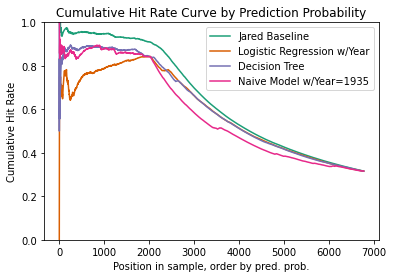

In [53]:
mod_list = [baseline_y_hat[:,1], logreg_test_preds[:,1], dtc_test_preds[:,1], nm_preds]

plot_hit_rate_curve(Ytest['dangerous'].astype(int), mod_list, 
                    labels=['Jared Baseline', 'Logistic Regression w/Year', 'Decision Tree',
                           f'Naive Model w/Year={year}'], plot_probs=False)